In [1]:
import requests
import json
import math
import chess, chess.engine, chess.pgn
from io import StringIO
import random

import numpy as np
from PIL import Image
import pyvips
from matplotlib import pyplot as plt
import matplotlib

%matplotlib inline 

In [2]:
player = 'bobhaffner'

# get game archives
r = requests.get(f'https://api.chess.com/pub/player/{player}/games/archives')
game_archive_dict = json.loads(r.text)
game_archive_dict

{'archives': ['https://api.chess.com/pub/player/bobhaffner/games/2022/07',
  'https://api.chess.com/pub/player/bobhaffner/games/2022/08',
  'https://api.chess.com/pub/player/bobhaffner/games/2022/09',
  'https://api.chess.com/pub/player/bobhaffner/games/2022/10',
  'https://api.chess.com/pub/player/bobhaffner/games/2022/11',
  'https://api.chess.com/pub/player/bobhaffner/games/2022/12',
  'https://api.chess.com/pub/player/bobhaffner/games/2023/01',
  'https://api.chess.com/pub/player/bobhaffner/games/2023/02',
  'https://api.chess.com/pub/player/bobhaffner/games/2023/03',
  'https://api.chess.com/pub/player/bobhaffner/games/2023/04',
  'https://api.chess.com/pub/player/bobhaffner/games/2023/05']}

In [3]:
# get the latest game archive
r = requests.get(game_archive_dict['archives'][-1])
games_dict = json.loads(r.text)
f"{len(games_dict['games'])} games from {game_archive_dict['archives'][-1]}"

'21 games from https://api.chess.com/pub/player/bobhaffner/games/2023/05'

## Find the Goofs

In [4]:
# any move that drop the eval by more than the goof_threshold will be put in the flash card pile
# lower goof_threshold = more flash cards
# higher goof_threshold = less flash cards
goof_threshold = 150

stockfish_path = '/opt/homebrew/Cellar/stockfish/15/bin/stockfish'

# grab the latest game
game = games_dict['games'][-1]

# are we playing white or black
if game['white']['username'] == player:
    perspective = chess.WHITE
else:
    perspective = chess.BLACK

# create some python-chess objs    
# https://github.com/niklasf/python-chess
engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)
game = chess.pgn.read_game(StringIO(game['pgn']))
board = game.board()
moves = game.mainline_moves()

# these next two will be keeping track of info from the prior move
prior_eval = None
engine_move = None

# create a list to keep track of our goofs
goofs = []

# iterate thru each move and eval the position after each one
for i, move in enumerate(moves):
    
    board.push(move)
    info = engine.analyse(board, limit=chess.engine.Limit(time=.1))
    
    _eval = info["score"].pov(perspective).score(mate_score=100000)

    # was this move a goof
    if prior_eval and _eval < prior_eval and abs(prior_eval - _eval) >= goof_threshold:
        
        # create a dict to house goof metadata and svgs
        goof = {}
        goof['move_num'] = math.ceil((i + 1) / 2)
        goof['goof_factor'] = abs(prior_eval - _eval)
        goof['engine_move'] = engine_move 
        
        arrow_player_move = chess.svg.Arrow(move.from_square, move.to_square, color='red')
        goof['svg'] = chess.svg.board(board,
                                      arrows=[arrow_player_move], 
                                      orientation=perspective, 
                                      size=500)
        goof['svg_with_engine_move'] = chess.svg.board(board,
                                                       arrows=[arrow_player_move, 
                                                               chess.svg.Arrow(engine_move.from_square, engine_move.to_square)], 
                                                       orientation=perspective, 
                                                       size=500)
        goofs.append(goof)
    
    prior_eval = _eval
    engine_move = info['pv'][0] if 'pv' in info else None

engine.quit()

f'{len(goofs)} goof(s) this game'

'4 goof(s) this game'

## Display the Goofs

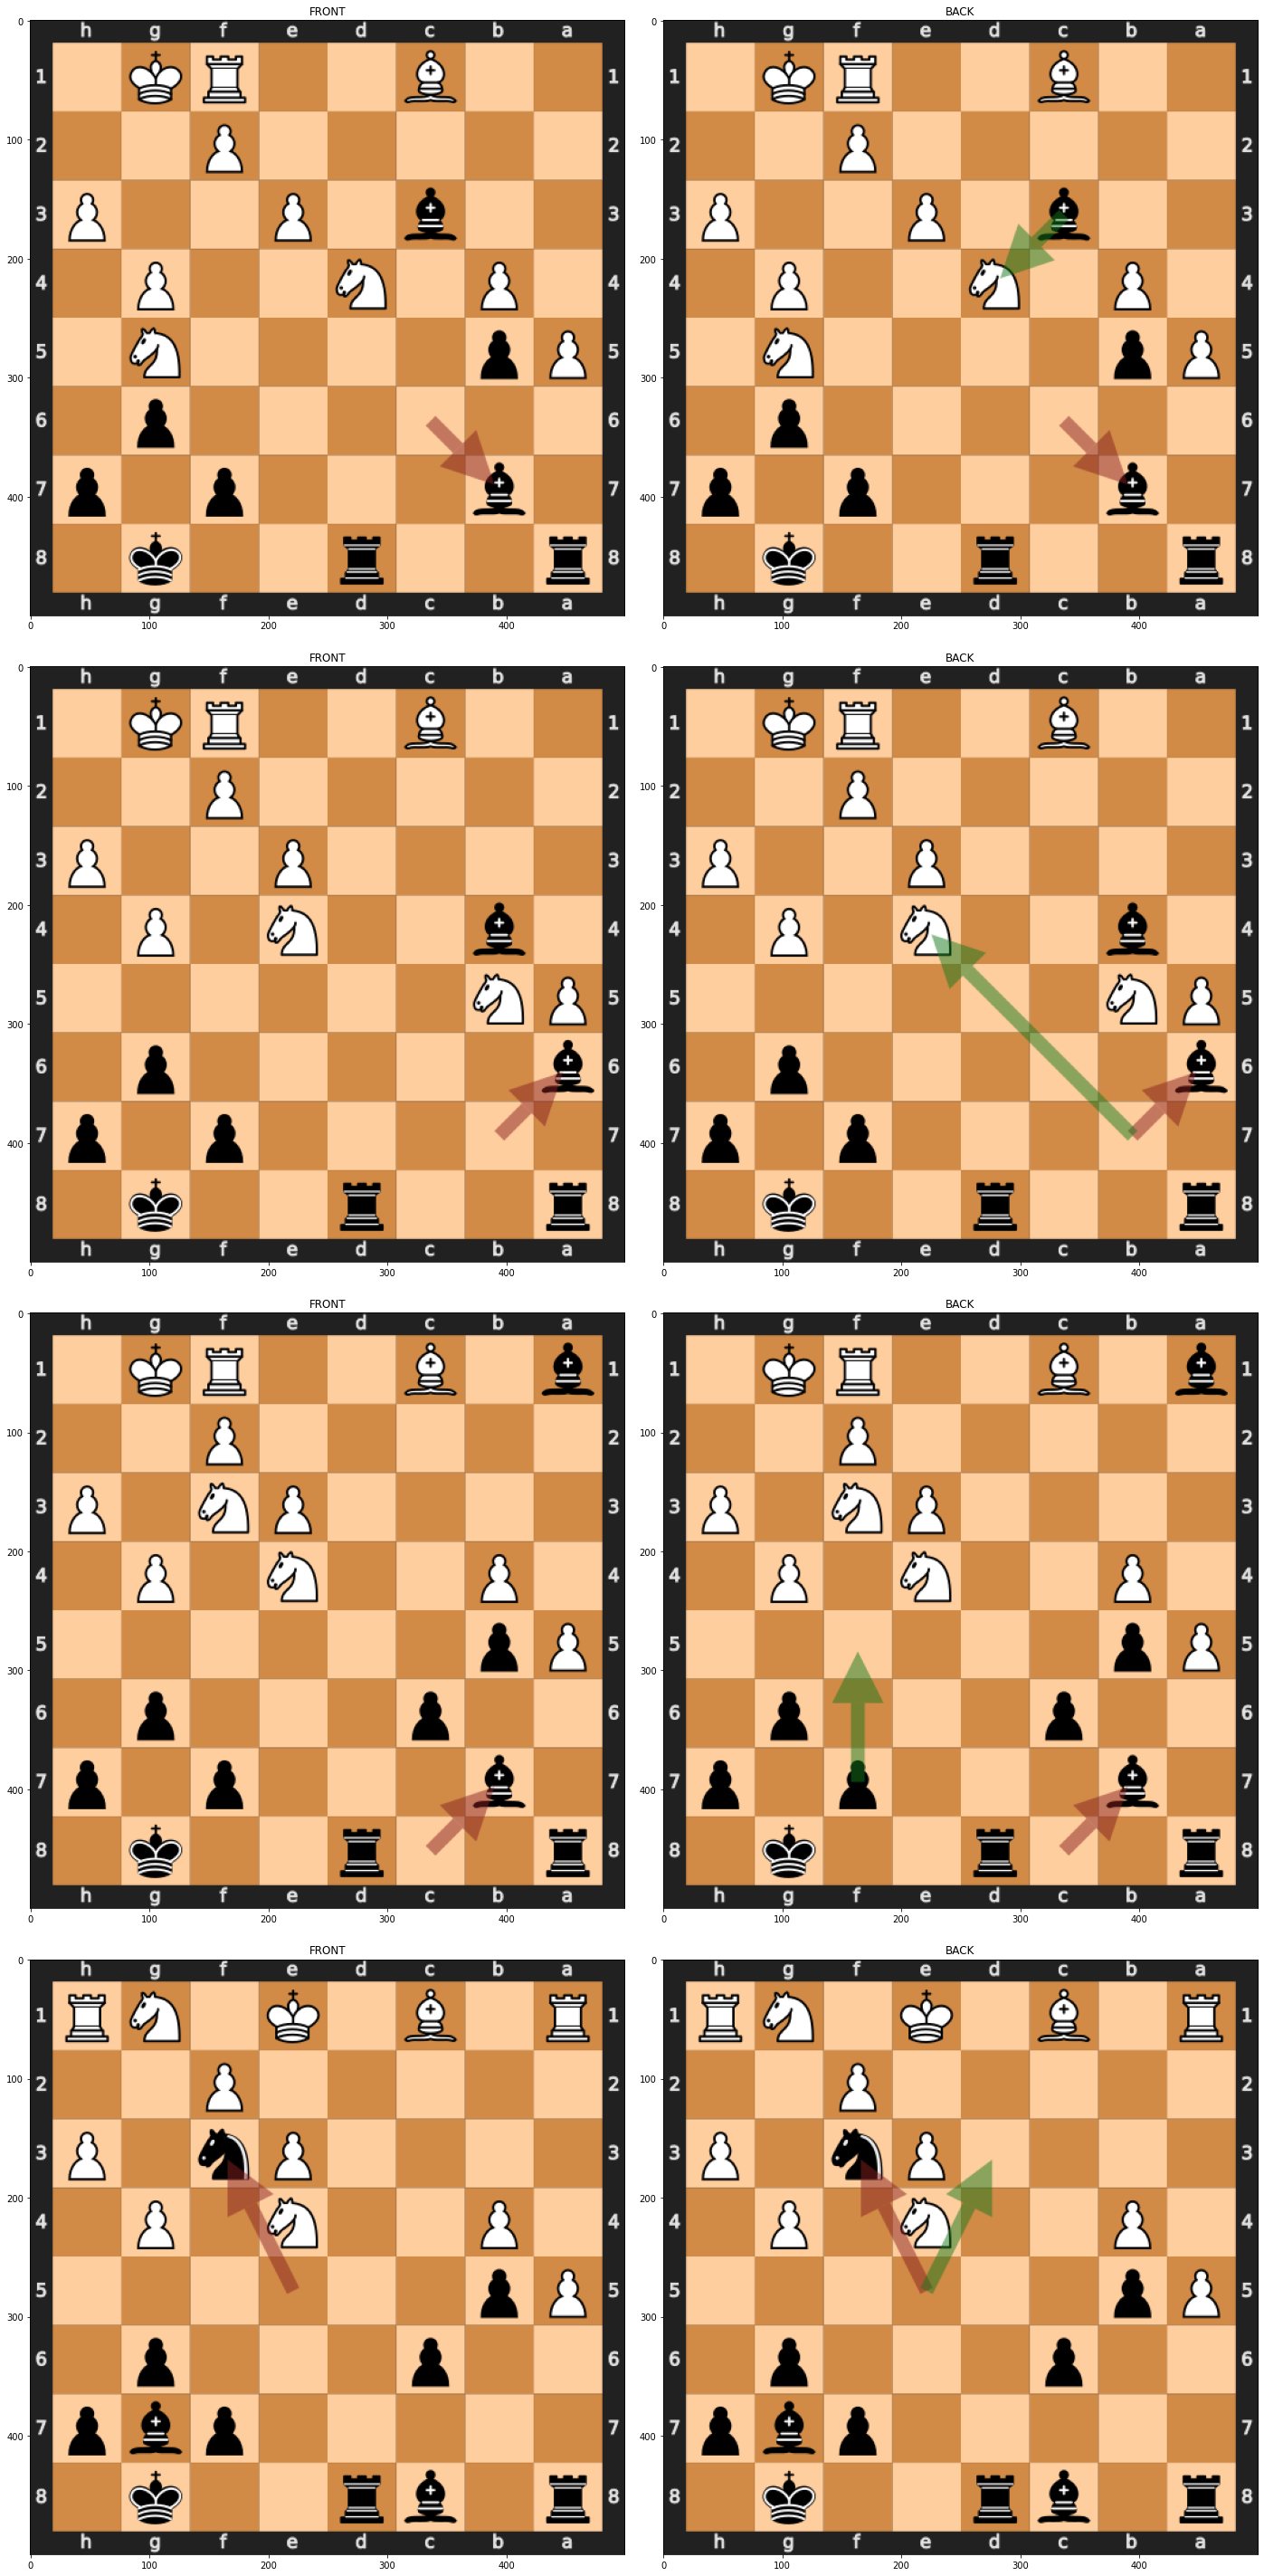

In [5]:
# lets ease into this by sorting best to worst
sorted_goofs = sorted(goofs, key=lambda d: d['goof_factor']) 

format_to_dtype = {
    'uchar': np.uint8,
    'char': np.int8,
    'ushort': np.uint16,
    'short': np.int16,
    'uint': np.uint32,
    'int': np.int32,
    'float': np.float32,
    'double': np.float64,
    'complex': np.complex64,
    'dpcomplex': np.complex128,
}

fig = plt.figure(figsize=(20, 40))
rows = len(goofs)

for i, goof in zip(range(1, rows * 2 + 1, 2), sorted_goofs):
    
    img = pyvips.Image.svgload_buffer(str.encode(goof['svg']))
    data = np.ndarray(buffer=img.write_to_memory(), dtype=format_to_dtype[img.format],
                   shape=[img.height, img.width, img.bands])
    axl = fig.add_subplot(rows, 2, i)
    axl.set_title('FRONT')
    plt.imshow(img)
    
    img_with_engine_move = pyvips.Image.svgload_buffer(str.encode(goof['svg_with_engine_move']))
    data = np.ndarray(buffer=img.write_to_memory(), dtype=format_to_dtype[img.format],
                   shape=[img.height, img.width, img.bands])
    axl = fig.add_subplot(rows, 2, i + 1)
    axl.set_title('BACK')
    plt.imshow(img_with_engine_move)
    
plt.rcParams.update({'font.size': 22})
fig.tight_layout()
plt.savefig('images/flash_cards.jpg')
plt.show()